# Example 3: -  Including systematics

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we will demonstrate how to include systematics in a MadMiner analysis. As physics example, we will consider $ttH$ production at parton level, with smearing functions. 

## Preparations

Let us first load all the python libraries again

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis
from madminer.sampling import combine_and_shuffle
from madminer.lhe import LHEProcessor
from madminer.sampling import SampleAugmenter
from madminer.plotting import plot_distributions

Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5. **This needs to be updated by the user**

In [2]:
mg_dir = '/Users/felixkling/work/MG5_aMC_v2_6_2'

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Setup

### 1a) Parameter Space

Let us first define the theory parameters. We are again using the `HEL` model. In partocular we have the following opertors which could effect $ttH$ production:
- `cu`: $\mathcal{L}=\frac{c_u}{v^2} (H^\dagger H) (H^\dagger \cdot \bar{Q}_L) u_R$. This operator effects the htt/hhtt and probably also ggg coupling  --> Rescales Yukawa Coupling
- `cG`: $\mathcal{L}=\frac{g_s^2 c_G}{m_W^2} (H^\dagger H) G_{\mu\nu}^a G_a^{\mu\nu}$. This operator effects the hgg/hhgg/hggg and probably also ggg coupling --> Rescales Gluon Coupling
- `cuG`: $\mathcal{L}=\frac{4g_s c_{uG}}{m_W^2} y_u  (H^\dagger \cdot \bar{Q}_L)  \gamma^{\mu\nu} T_a u_R G^a_{\mu\nu}$. This operator effects the hgtt/hggtt and probably also gtt/ggtt coupling
- `cH`: $\mathcal{L}=\frac{c_{H}}{2v^2} \partial^\mu (H^\dagger H) \partial_\mu (H^\dagger H) $ . This operator effects the htt/hhh coupling --> Rescales Yukawa + Self Coupling
- `c6`: $\mathcal{L}=\frac{c_{6} \lambda}{v^2} (H^\dagger H)^3$. This operator effects the hhh coupling --> Rescales Self Coupling
- `c3G`: $\mathcal{L}=\frac{g_s^3 c_{3G}}{m_W^2}f_{abc} G^a_{\mu\nu} G^{\nu b}_\rho G^{\rho \mu c}$. This operator effects the ggg coupling
- `c2G`: $\mathcal{L}=\frac{c_{2G}}{m_W^2}D_\mu  G^a_{\mu\nu} D_\rho G^{\rho \nu}_a$. This operator effects the ggg coupling

In [4]:
def setup_benchmark(miner,operators):
    if "cu" in operators:
        miner.add_parameter(
            lha_block='newcoup',
            lha_id=4,
            parameter_name='cu',
            morphing_max_power=2,
            parameter_range=(-10.,10.)
        )
    if "cG" in operators:
        miner.add_parameter(
            lha_block='newcoup',
            lha_id=12,
            parameter_name='cG',
            morphing_max_power=2,
            parameter_range=(-10.,10.)
        )
    if "cuG" in operators:
        miner.add_parameter(
            lha_block='newcoup',
            lha_id=23,
            parameter_name='cuG',
            morphing_max_power=2,
            parameter_range=(-10.,10.)
        )
    if "cH" in operators:
        miner.add_parameter(
            lha_block='newcoup',
            lha_id=1,
            parameter_name='cH',
            morphing_max_power=2,
            parameter_range=(-10.,10.)
        )
    if "c6" in operators:
        miner.add_parameter(
            lha_block='newcoup',
            lha_id=3,
            parameter_name='c6',
            morphing_max_power=2,
            parameter_range=(-10.,10.)
        )
    if "c3G" in operators:
        miner.add_parameter(
            lha_block='newcoup',
            lha_id=30,
            parameter_name='c3G',
            morphing_max_power=2,
            parameter_range=(-10.,10.)
        )
    if "c2G" in operators:
        miner.add_parameter(
            lha_block='newcoup',
            lha_id=33,
            parameter_name='c2G',
            morphing_max_power=2,
            parameter_range=(-10.,10.)
        )

In [5]:
miner = MadMiner()
useoperator=['cu','cG','cuG','cH','c6','c3G','c2G']
setup_benchmark(miner,useoperator)


14:58 madminer.core        INFO    Added parameter cu (LHA: newcoup 4, maximal power in squared ME: (2,), range: (-10.0, 10.0))
14:58 madminer.core        INFO    Added parameter cG (LHA: newcoup 12, maximal power in squared ME: (2,), range: (-10.0, 10.0))
14:58 madminer.core        INFO    Added parameter cuG (LHA: newcoup 23, maximal power in squared ME: (2,), range: (-10.0, 10.0))
14:58 madminer.core        INFO    Added parameter cH (LHA: newcoup 1, maximal power in squared ME: (2,), range: (-10.0, 10.0))
14:58 madminer.core        INFO    Added parameter c6 (LHA: newcoup 3, maximal power in squared ME: (2,), range: (-10.0, 10.0))
14:58 madminer.core        INFO    Added parameter c3G (LHA: newcoup 30, maximal power in squared ME: (2,), range: (-10.0, 10.0))
14:58 madminer.core        INFO    Added parameter c2G (LHA: newcoup 33, maximal power in squared ME: (2,), range: (-10.0, 10.0))


### 1b) Benchmarks

Define SM benchmarks by hand, and scan to find remaining benchmarks.

In [6]:
miner.add_benchmark( {useoperator[0]:0., useoperator[1]:0., 
                      useoperator[2]:0., useoperator[3]:0., 
                      useoperator[4]:0., useoperator[5]:0., 
                      useoperator[6]:0. }, 'sm')

14:58 madminer.core        INFO    Added benchmark sm: cH = 0.00e+00, c3G = 0.00e+00, cG = 0.00e+00, cuG = 0.00e+00, c2G = 0.00e+00, c6 = 0.00e+00, cu = 0.00e+00)


In [7]:
miner.set_morphing(
    include_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

14:58 madminer.core        INFO    Optimizing basis for morphing
14:59 madminer.core        INFO    Added benchmark sm: cu = 0.00e+00, cG = 0.00e+00, cuG = 0.00e+00, cH = 0.00e+00, c6 = 0.00e+00, c3G = 0.00e+00, c2G = 0.00e+00)
14:59 madminer.core        INFO    Added benchmark morphing_basis_vector_1: cu = 0.88, cG = 8.02, cuG = 6.95, cH = 7.55, c6 = 2.33, c3G = -9.73e-01, c2G = 2.49)
14:59 madminer.core        INFO    Added benchmark morphing_basis_vector_2: cu = -9.94e+00, cG = 5.09, cuG = -2.14e+00, cH = 5.06, c6 = -4.99e+00, c3G = 2.23, c2G = 1.24)
14:59 madminer.core        INFO    Added benchmark morphing_basis_vector_3: cu = -8.50e+00, cG = 2.72, cuG = 3.83, cH = -7.97e+00, c6 = 9.92, c3G = 7.89, c2G = 5.79)
14:59 madminer.core        INFO    Added benchmark morphing_basis_vector_4: cu = 7.50, cG = 7.90, cuG = -5.43e+00, cH = 4.22, c6 = -1.48e+00, c3G = 9.34, c2G = -8.74e-01)
14:59 madminer.core        INFO    Added benchmark morphing_basis_vector_5: cu = -1.90e-02, cG = 7.53, 

In [8]:
#fig = plot_2d_morphing_basis(
#    miner.morpher,
#    xlabel=useoperator[0],
#    ylabel=useoperator[1],
#    xrange=(-10,10),
#    yrange=(-10,10)
#)

### 1c) Systematics

Systematics can be added using the `madminer.set_systematics()` command. In particular, we consider two sorts of systematics: scale variations and pdf variations. The setting is described by the following three inputs
- `scales`: Whether only the regularization scale (`"mur"`), only the factorization scale (`"muf"`), both simultanously with $\mu=\mu_F=\mu_R$ (`"together"`) or both independently (`"independent"`) are varied.
- `scale_variation`: If not `None`, the regularization and / or factorization scales are varied. A tuple like ($\mu_{max},\mu_{min}$) specifies the factors with which they are varied. Here $\mu_{max}$ refers to the name of the benchmark with $\nu = 1$, while $\mu_{min}$ is either `None` or refers to the name of the benchmark with $\nu = -1$. Note that if more than two scales are given, currently only first and last scale are used.
- `pdf_variation`: If not `None`, the PDFs are varied. The option is passed along to the `--pdf` option of MadGraph's systematics module. See https://cp3.irmp.ucl.ac.be/projects/madgraph/wiki/Systematics for a list. For example, the option `"90900"` would run over all the eigenvectors of the PDF4LHC15_nlo_30 set. 

In [9]:
#miner.set_systematics(
#    scale_variation=(0.5,1,2), 
#    scales="independent", 
#    pdf_variation="90900"
#)

### 1d) Save setup

In [10]:
miner.save('data/madminer_example.h5')

14:59 madminer.core        INFO    Saving setup (including morphing) to data/madminer_example.h5


## 2. Event Generation

Load MadMiner again

In [11]:
miner.load('data/madminer_example.h5')

14:59 madminer.core        INFO    Found 7 parameters:
14:59 madminer.core        INFO       cu (LHA: newcoup 4, maximal power in squared ME: (2,), range: (-10.0, 10.0))
14:59 madminer.core        INFO       cG (LHA: newcoup 12, maximal power in squared ME: (2,), range: (-10.0, 10.0))
14:59 madminer.core        INFO       cuG (LHA: newcoup 23, maximal power in squared ME: (2,), range: (-10.0, 10.0))
14:59 madminer.core        INFO       cH (LHA: newcoup 1, maximal power in squared ME: (2,), range: (-10.0, 10.0))
14:59 madminer.core        INFO       c6 (LHA: newcoup 3, maximal power in squared ME: (2,), range: (-10.0, 10.0))
14:59 madminer.core        INFO       c3G (LHA: newcoup 30, maximal power in squared ME: (2,), range: (-10.0, 10.0))
14:59 madminer.core        INFO       c2G (LHA: newcoup 33, maximal power in squared ME: (2,), range: (-10.0, 10.0))
14:59 madminer.core        INFO    Found 36 benchmarks:
14:59 madminer.core        INFO       sm: cu = 0.00e+00, cG = 0.00e+00, cuG =

We now run MadMiner for the signal: 

In [12]:
miner.run(
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/signal',
    log_directory='logs/signal',
    sample_benchmark='sm',
    proc_card_file='cards/proc_card_signal.dat',
    param_card_template_file='cards/param_card_signal.dat',
    run_card_file='cards/run_card.dat',
    pythia8_card_file=None,
    initial_command='source ~/.bashrc'
)

14:59 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal.dat at ./mg_processes/signal
14:59 madminer.core        INFO    Run 0
14:59 madminer.core        INFO      Sampling from benchmark: sm
14:59 madminer.core        INFO      Original run card:       cards/run_card.dat
14:59 madminer.core        INFO      Original Pythia8 card:   None
14:59 madminer.core        INFO      Copied run card:         /madminer/cards/run_card_0.dat
14:59 madminer.core        INFO      Copied Pythia8 card:     None
14:59 madminer.core        INFO      Param card:              /madminer/cards/param_card_0.dat
14:59 madminer.core        INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
14:59 madminer.core        INFO      Log file:                run_0.log
14:59 madminer.core        INFO    Creating param and reweight cards in ./mg_processes/signal//madminer/cards/param_card_0.dat, ./mg_processes/signal//madminer/cards/reweight_card_0.dat
14:59 ma

## 3. Extract Parton Level Observables / Weights 

### 3a) Setting up LHEProcessor 

We first initialize the the LHEProcessor and add the LHE file

In [13]:
lhep = LHEProcessor('data/madminer_example.h5')

lhep.add_sample(
    'mg_processes/signal/Events/run_01/unweighted_events.lhe.gz',
    sampled_from_benchmark="sm",
    k_factor=1.0
)

### 3b) Smearing Functions

Instead of performing a proper proper shower and detector simulation, we can simulate smearing effects at parton level smearing through smearing functions. Here we will assume a simple 10% uncertainty on the tau energy measurements and a $\pm 0.05$ smearing for tau $\eta$ and $\phi$. The transverse momenta of the taus are then derived from the smeared energy and the on-shell condition for the quarks (this is what `pt_resolution_abs=None` does). The leptons from the Z-boson decay are assumed to be measured perfectly (otherwise we'd have to call `set_smearing` another time with `pdgis=[-13 13]`).

In [14]:
#lhep.set_smearing(
#    pdgids=[-15, 15],   
#    energy_resolution_abs=0.05,
#    energy_resolution_rel=0,
#    pt_resolution_abs=None,
#    pt_resolution_rel=None,
#    eta_resolution_abs=0.02,
#    eta_resolution_rel=0,
#    phi_resolution_abs=0.02,
#    phi_resolution_rel=0,
#)

### 3c) Add Observables and Cuts

We will now add some observables.  In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `tau[i]`,  `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

Here we on a small set of higher-level observables: 

In [15]:
lhep.add_observable('pt_t1', 'p[0].pt',required=True)
lhep.add_observable('pt_H', 'p[2].pt',required=True)
lhep.add_observable('eta_H', 'p[0].eta',required=True)
lhep.add_observable('eta_t1', 'p[2].eta',required=True)
lhep.add_observable('m_tt', '(p[0]+p[1]).m',required=True)
lhep.add_observable('m_ttH', '(p[0]+p[1]+p[2]).m',required=True)

We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables. As example, we consider cuts on the invariant di-lepton / di-tau mass:

In [16]:
#lhep.add_cut('m_Z > 86')
#lhep.add_cut('m_Z < 96')
#lhep.add_cut('(tau[0]+tau[1]).m > 120')
#lhep.add_cut('(tau[0]+tau[1]).m < 130')

### 3d) Run and Save 

We can now run `analyse_samples` to calculate all observables from the LHE file(s) generated before, apply the smearing, and check which events pass the cuts:

In [17]:
lhep.analyse_samples() 

15:01 madminer.lhe         INFO    Analysing LHE sample mg_processes/signal/Events/run_01/unweighted_events.lhe.gz
15:01 madminer.utils.inter INFO      1000 events pass everything
15:01 madminer.utils.inter INFO      Out of these, 0 events contain negative weights


Finally, let's save everything

In [18]:
lhep.save('data/madminer_lhedata_signal.h5')

### 3e) Plot Distributions

Let us now plot some distributions. This can also be done using the `plot_distributions` function. As before the function requires
- `filename`: the name of the file with the processed LHE data
- `parameter_points`: a list of benchmarks, which can either be specified by there name (such as `sm`) or manually (for example `np.array([0,1])`). 
- `line_labels`: names for the benchmarks
- `observables`: list of observables to be plotted (when `None`, all observables are plotted)
We can also plot the uncertainties using the option `uncertainties='nuisance'`. By default, the full uncertainy band using all considered nuicanse parameter is shown. To obtain the uncertainty, MadMiner created a set of `n_toys` (default 100) Monte Carlo sample distributions to estimate the 68% CL band. Additionally, MadMiner can also show a set of `N` of these Monte Carlo toy samples using the option `draw_nuisance_toys=N`. 

More options, in particular regarding plotting, can be found via the command `help(plot_distributions)`. 

15:08 madminer.sampling    INFO    Loading data from data/madminer_lhedata_signal.h5
15:08 madminer.sampling    INFO    Found 7 parameters
15:08 madminer.sampling    INFO    Did not find nuisance parameters
15:08 madminer.sampling    INFO    Found 36 benchmarks, of which 36 physical
15:08 madminer.sampling    INFO    Found 6 observables
15:08 madminer.sampling    INFO    Found 1000 events
15:08 madminer.sampling    INFO    Found morphing setup with 36 components


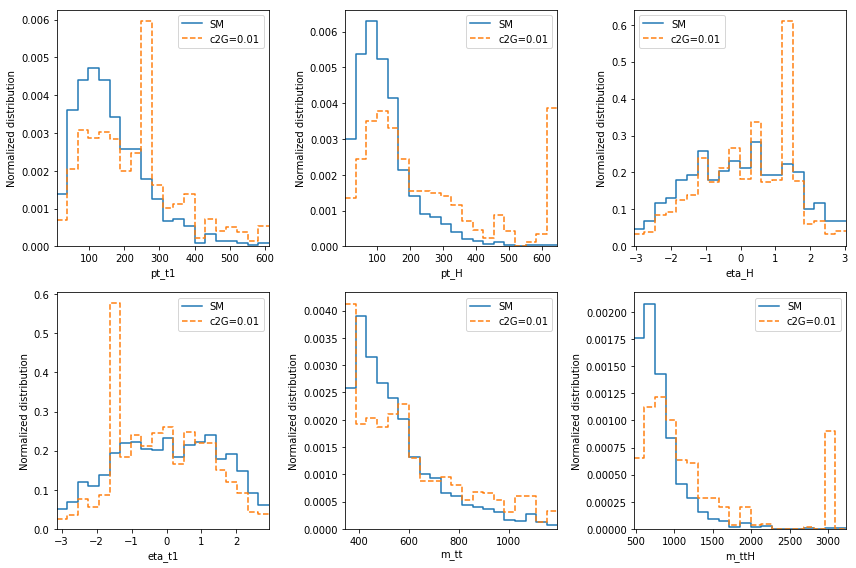

In [56]:
_ = plot_distributions(
    filename='data/madminer_lhedata_signal.h5',
    parameter_points=['sm', 
#                      np.array([.1,0,0,0,0,0,0]), 
#                      np.array([0,.01,0,0,0,0,0]),
#                      np.array([0,0,.01,0,0,0,0]),
#                      np.array([0,0,0,.1,0,0,0]),
#                      np.array([0,0,0,0,10,0,0]),
#                      np.array([0,0,0,0,0,0.001,0]),
                      np.array([0,0,0,0,0,0,.01]),
                     ],
    line_labels=['SM', 
#                 useoperator[0]+'=0.01',
#                 useoperator[1]+'=0.01',
#                 useoperator[2]+'=0.01',
#                 useoperator[3]+'=0.01',
#                 useoperator[4]+'=0.01',
#                 useoperator[5]+'=0.01',
                 useoperator[6]+'=0.01',
                ],
#    colors=['C0','C1','black'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

- `cu`: $\mathcal{L}=\frac{c_u}{v^2} (H^\dagger H) (H^\dagger \cdot \bar{Q}_L) u_R$
   - Visible effects for cu=0.1, rate only
- `cG`: $\mathcal{L}=\frac{g_s^2 c_G}{m_W^2} (H^\dagger H) G_{\mu\nu}^a G_a^{\mu\nu}$. 
   - Visible effects for cG=0.001,changes kinematics
- `cuG`: $\mathcal{L}=\frac{4g_s c_{uG}}{m_W^2} y_u  (H^\dagger \cdot \bar{Q}_L)  \gamma^{\mu\nu} T_a u_R G^a_{\mu\nu}$. 
   - Visible effects for cuG=0.001, changes kinematics
- `cH`: $\mathcal{L}=\frac{c_{H}}{2v^2} \partial^\mu (H^\dagger H) \partial_\mu (H^\dagger H) $ . 
   - Visible effects for cH=0.1, rate only
- `c6`: $\mathcal{L}=\frac{c_{6} \lambda}{v^2} (H^\dagger H)^3$. 
   - Visible effects for c6=1, changes kinematics 
- `c3G`: $\mathcal{L}=\frac{g_s^3 c_{3G}}{m_W^2}f_{abc} G^a_{\mu\nu} G^{\nu b}_\rho G^{\rho \mu c}$. 
   - Visible effects for c3G=0.001, changes kinematics
- `c2G`: $\mathcal{L}=\frac{c_{2G}}{m_W^2}D_\mu  G^a_{\mu\nu} D_\rho G^{\rho \nu}_a$. 
   - Visible effects for c3G=0.01, changes kinematics

We can also only consider a subset of nuisance parameter. In the following example, we separatly show the uncertainties from scale and PDF variations.  

In [20]:
"""
nuisance_scale=np.array([i for i in range(0,2)])
nuisance_pdf=np.array([i for i in range(2,33)])

fig_scale = plot_distributions(
     filename='data/madminer_lhedata_signal.h5',
    parameter_points=['sm',np.array([10,0]),np.array([0,10])],
    line_labels=['SM',r'$\theta_0=10$',r'$\theta_1=10$'],
    observables=['m_Z','m_ZH','dphi_mumu'],
    uncertainties='nuisance',
    n_bins=20,               
    normalize=False,  
    nuisance_parameters=nuisance_scale,
)

fig_pdf = plot_distributions(
     filename='data/madminer_lhedata_signal.h5',
    parameter_points=['sm',np.array([10,0]),np.array([0,10])],
    line_labels=['SM',r'$\theta_0=10$',r'$\theta_1=10$'],
    observables=['m_Z','m_ZH','dphi_mumu'],
    uncertainties='nuisance',
    n_bins=20,               
    normalize=False,  
    nuisance_parameters=nuisance_pdf,
)
"""

u"\nnuisance_scale=np.array([i for i in range(0,2)])\nnuisance_pdf=np.array([i for i in range(2,33)])\n\nfig_scale = plot_distributions(\n     filename='data/madminer_lhedata_signal.h5',\n    parameter_points=['sm',np.array([10,0]),np.array([0,10])],\n    line_labels=['SM',r'$\theta_0=10$',r'$\theta_1=10$'],\n    observables=['m_Z','m_ZH','dphi_mumu'],\n    uncertainties='nuisance',\n    n_bins=20,               \n    normalize=False,  \n    nuisance_parameters=nuisance_scale,\n)\n\nfig_pdf = plot_distributions(\n     filename='data/madminer_lhedata_signal.h5',\n    parameter_points=['sm',np.array([10,0]),np.array([0,10])],\n    line_labels=['SM',r'$\theta_0=10$',r'$\theta_1=10$'],\n    observables=['m_Z','m_ZH','dphi_mumu'],\n    uncertainties='nuisance',\n    n_bins=20,               \n    normalize=False,  \n    nuisance_parameters=nuisance_pdf,\n)\n"

Note that the uncertainty mainly effects the signal normalization, not the signal distribution. This can be seen looking at the normalized distributions via `normalize=True`

In [21]:
"""
fig_pdf = plot_distributions(
     filename='data/madminer_lhedata_signal.h5',
    parameter_points=['sm',np.array([10,0]),np.array([0,10])],
    line_labels=['SM',r'$\theta_0=10$',r'$\theta_1=10$'],
    observables=['m_Z','m_ZH','dphi_mumu'],
    uncertainties='nuisance',
    n_bins=20,               
    normalize=True,  
)
"""

u"\nfig_pdf = plot_distributions(\n     filename='data/madminer_lhedata_signal.h5',\n    parameter_points=['sm',np.array([10,0]),np.array([0,10])],\n    line_labels=['SM',r'$\theta_0=10$',r'$\theta_1=10$'],\n    observables=['m_Z','m_ZH','dphi_mumu'],\n    uncertainties='nuisance',\n    n_bins=20,               \n    normalize=True,  \n)\n"